# 1 Import and Init

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random 
seed=1996
np.random.seed(seed)
random.seed(seed)

In [3]:
N,k=150,10
learning_rate=0.001
mu=np.zeros(k)
sigma=2 # " dans la papier sigma_square=100"
std=sigma*np.identity(k)
beta_none=np.array([(i+1)/100 for i in range(k) ]).reshape(k,1)
X=np.random.randn(N,k)
B=10000
beta_none[1:3]

array([[0.02],
       [0.03]])

In [4]:
min_=np.mean(X,axis=0)
max_=np.max(X,axis=0)
X=(X-min_)/max_-min_

#  2 DGP

In [5]:
def indicator(x,threshold=0) :
    if x>=threshold:
        return int(1)
    else:
            return int(0)

In [6]:
X.shape,beta_none.shape

((150, 10), (10, 1))

In [7]:
Y=np.zeros(N).reshape(N,1)
for i in range(N):
    z=np.random.randn(1)
    Y[i]=indicator(np.dot(X[i],beta_none))

(array([79.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 71.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

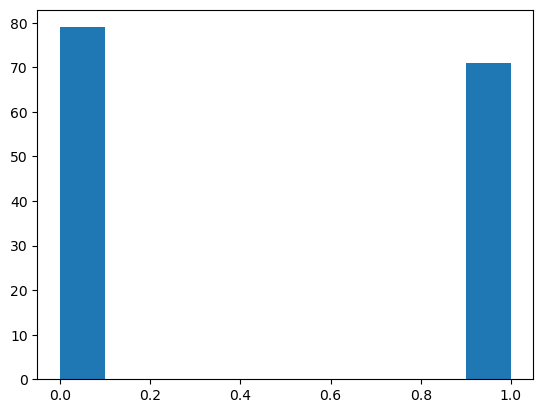

In [8]:
plt.hist(Y)

In [9]:
def log_lik(X,Y,beta):
    beta_t=beta.reshape(1,k)
    X_t=X.transpose()
    ll=np.dot(beta_t,np.dot(X_t,Y))
    for i in range(N):
        ll=ll-np.log(1+np.exp(np.dot((X[i,:].reshape(k,1)),beta.reshape(1,k))))
    return ll[0][0]

In [10]:
log_lik(X,Y,beta_none-8)

-748.095393719024

In [12]:
def density_value(beta,mu,var_):
    beta=beta.reshape(k,1)
    mu=mu.reshape(k,1)
    gap=beta-mu
    gap_t=gap.transpose()
    pi=np.pi
    det=np.linalg.det(var_)
    in_var=np.linalg.inv(var_)
    const_=np.sqrt(((2*np.pi)**k)*det)
    inv_const=np.round(1/const_,100)
    v=np.dot(gap_t,np.dot(in_var,gap))
    x=np.exp((-1/2)*v)
    value=inv_const*x
    return value[0][0]

In [13]:
def link_fun(x):
    return 1/(1+np.exp(-x))

In [14]:
def get_Lambda_Matrix(X,beta):
    beta_t=beta.reshape(k,1)
    left_real_values=[link_fun(np.dot(X[i,:].reshape(1,k),beta_t)[0][0]) for i in range(N)]
    real_values=[np.round(left_real_values[i]*(1-left_real_values[i]),100) for i in range(N)]
    Lambda_matrix=np.diag(real_values)

    return Lambda_matrix


In [15]:
get_Lambda_Matrix(X,beta_none).shape

(150, 150)

In [16]:
def Tensor_metric_G(X,beta):
    Lambda_Matrix=get_Lambda_Matrix(X,beta)
    X_t=X.transpose()
    G_of_beta=X_t@(Lambda_Matrix@X)-sigma*np.identity(k)

    return G_of_beta

In [17]:
Tensor_metric_G(X,beta_none).shape

(10, 10)

In [18]:
def compute_V_i(X,i,beta):
    #diag_elts=[(1-2*link_fun_value(X[n],beta_))*X[n,i] for n in range(N)]
    beta_t=beta.reshape(1,k)
    diag_elts=[(1-2*link_fun(np.dot(X[i,:].reshape(k,1),beta_t)[0][0])) for i in range(N)]
    V_i_Matrix=np.diag(diag_elts)
    return V_i_Matrix

In [19]:
def get_G_partial_derivative(X,i,beta):
    X_t=X.transpose()
    Lambda_Matrix=get_Lambda_Matrix(X,beta) #get_Lambda_Matrix(X,beta_none)
    V_i_Matrix=compute_V_i(X,i,beta)
    G_partial_derivative_Matrix=X_t@Lambda_Matrix@V_i_Matrix@X

    return G_partial_derivative_Matrix

In [20]:
compute_V_i(X,0,beta_none).shape

(150, 150)

In [21]:
get_G_partial_derivative(X,0,beta_none).shape

(10, 10)

In [22]:
def grad_log_lik(X,Y,beta):
    X_t=X.transpose()
    gll=X_t@Y
    for n in range(N):
        value=np.dot(X[i,:],beta)[0]
        gll=gll-link_fun(value)*(X[i,:].reshape(k,1))
    return gll
    

In [23]:
def proposal_Distribution_mean(X,Y,beta):
    e=learning_rate
    G=Tensor_metric_G(X,beta) #Tensor_metric_G(X,beta)
    inv_G=np.linalg.inv(G)

    term2=(1/2)*(e**2)*inv_G@grad_log_lik(X,Y,beta)
    term3=np.zeros(k)
    term4=np.zeros(k)
    for j in range(k):
        term3=term3-(e**2)*(inv_G@get_G_partial_derivative(X,j,beta)@inv_G)[:,j]
    for j in range(k):
        terme4=term4+(e**2)*inv_G[:,j]*np.trace(inv_G@get_G_partial_derivative(X,j,beta))

    proposal_mean=beta.reshape(k,1)+term2+term3.reshape(k,1)+term4.reshape(k,1)
    return proposal_mean
    

In [24]:
proposal_Distribution_mean(X,Y,beta_none).shape


(10, 1)

In [25]:
def get_matrix_sqrt(X):
    U, s, V = np.linalg.svd(X)

# Racine carrée des valeurs singulières
    s_sqrt = np.sqrt(s)

# Reconstruction de la matrice racine carrée
    X_sqrt = U.dot(np.diag(s_sqrt)).dot(V)

    return X_sqrt

In [26]:
def proposal_Distribution_std_matrix_fun(X,beta): # c'est plutot l'cartype
    e=learning_rate
    G=Tensor_metric_G(X,beta)
    inv_G=np.linalg.inv(G)
    inv_G_sqrt=get_matrix_sqrt(inv_G)
    
    return e*inv_G_sqrt

In [27]:
proposal_Distribution_std_matrix_fun(X,beta_none).shape

(10, 10)

In [28]:
def beta_drawner(X,Y,beta):
    mean_=proposal_Distribution_mean(X,Y,beta) #( 10,1)
    std_matrix=proposal_Distribution_std_matrix_fun(X,beta)  # (10,10)
    Z=np.random.randn(k,1)
    proposed_teta=mean_+std_matrix@Z
    
    return proposed_teta

In [29]:
beta_drawner(X,Y,beta_none).shape

(10, 1)

In [30]:
def Acceptance_Rati(beta1, beta2, X, Y, ):

    ee=0.00001
    q_mu1=proposal_Distribution_mean(X,Y,beta1)
    q_mu2=proposal_Distribution_mean(X,Y,beta2)
    #   prior density
    var_=std@(std.transpose())
    p1=density_value(beta1,mu,var_)
    p2=density_value(beta2,mu,var_)
    # proposal density 
    std1=proposal_Distribution_std_matrix_fun(X,beta1)
    std2=proposal_Distribution_std_matrix_fun(X,beta2)
    q_var1=std1@(std1.transpose())
    q_var2=std1@(std2.transpose())


    q1=density_value(beta1,q_mu1,q_var1)
    q2=density_value(beta2,q_mu2,q_var2)
    rate= ee+ ((p2*q1)+ee)/((p1*q2)+ee)
    return np.log(rate)



In [31]:
Acceptance_Rati(beta_none,beta_none,X,Y)

9.999950000398841e-06

In [32]:
def mMALA_one_iter(beta,X=X,Y=Y):
    prop_beta=beta_drawner(X,Y,beta)
    log_rate=Acceptance_Rati(beta,prop_beta,X=X,Y=Y)
    u=np.random.uniform(0, 1)
    ee=0.00001
    if (log_rate>0) or (log_rate>np.log(u+ee)):
        return prop_beta
    else :
        return beta
     

In [33]:
mMALA_one_iter(beta_none)

array([[0.0090194 ],
       [0.0197417 ],
       [0.02982156],
       [0.04027588],
       [0.04903346],
       [0.05986887],
       [0.07049203],
       [0.07896181],
       [0.09086893],
       [0.09909638]])

In [34]:
def mMALA_Run(X=X,Y=Y,B=1,initial_state=np.zeros(k).reshape(k,1)):
    current_beta=initial_state
    beta_chaine=[]
    for i in range(B):
        current_beta=mMALA_one_iter(current_beta,X=X,Y=Y)
        beta_chaine.append(current_beta)

    return beta_chaine


In [35]:
chaine_long=mMALA_Run(B=100000)
last_valueF=chaine_long[0]
last_valueF[-1],beta_none[0]


In [ ]:
def predictor(X,beta_hat):
    Pred_Probas=np.zeros(N)
    Y_pred=np.zeros(N).
    for i in range(N):
        value=np.dot(X[i,:],beta_hat)[0]
        Pred_Probas[i]=link_fun(value)
        Y_pred[i]=indicator_fun(Pred_Probas[i]-0.5)

    return Y_pred

In [ ]:
beta_mMALA=chaine_long[-1]
y_pred = predictor(X,beta_hat)
y_pred.shape

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns



# Calculer la matrice de confusion
conf_matrix = confusion_matrix(Y, y_pred)

# Étiquettes des classes
class_names = ['Classe 0', 'Classe 1']

# Tracer la matrice de confusion
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Ajuster la taille de la police
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14}, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion')
plt.show()


In [ ]:
def plot_chaine_distr(chaine_,true_params=0,i=0,algo="mMALA"):
    data=[chaine_[i][0] for i in range(2000,B,1)]
    sns.distplot(data)
    plt.axvline(x=beta[i], color='red', linestyle='--')
    plt.xlabel(" Beta estimated ")
    plt.ylabel("Frequency")
    plt.title(" Distribution of beta ")
    plt.grid()

In [ ]:
chaine_l=mMALA_Run(B=2)
last_value0=chaine_0[0]
last_value0[-1],beta_none[0]
last_value0

In [687]:
chaine_9=MALA_Run(B=1000,initial_state=last_value8)
last_value9=chaine_9[-1]
last_value9[-1],beta_none[-1]

(array([0.00224504]), array([0.1]))

In [688]:
chaine_10=MALA_Run(B=1000,initial_state=last_value9)
last_value10=chaine_10[-1]
last_value10[-1],beta_none[-1]

(array([0.00201298]), array([0.1]))

In [689]:
chaine_11=MALA_Run(B=1000,initial_state=last_value10)
last_value11=chaine_11[-1]
last_value11[-1],beta_none[-1]

(array([0.00209686]), array([0.1]))

(array([143., 153., 126., 260., 222., 258., 275., 251., 154., 158.]),
 array([0.00088904, 0.00095409, 0.00101915, 0.0010842 , 0.00114925,
        0.00121431, 0.00127936, 0.00134441, 0.00140946, 0.00147452,
        0.00153957]),
 <BarContainer object of 10 artists>)

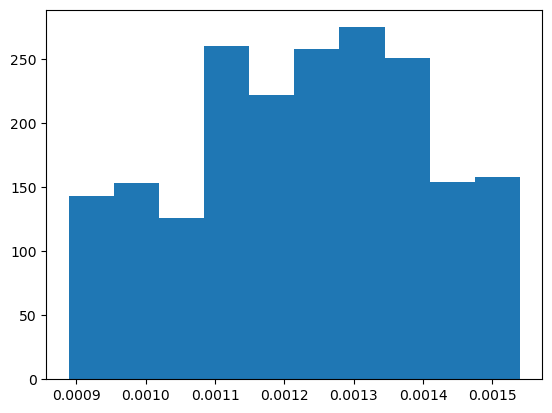